In [2]:
## import libaries
import pandas as pd
import numpy as np
import cv2
import os, sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
## load files
data = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print 'data size :', data.shape
print 'test size :', test.shape

np.random.seed(1234)
data.reindex(np.random.permutation(data.index))
num_train = int(0.80*data.shape[0])

train_data = data.iloc[0:num_train, :]
val_data = data.iloc[num_train:data.shape[0], :]

print 'train size : ', train_data.shape
print 'val size : ', val_data.shape

data size : (3215, 2)
test size : (1732, 1)
train size :  (2572, 2)
val size :  (643, 2)


In [4]:
# function to read image
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256,256))
    return img

# set path to read train and test image
TRAIN_PATH = './data/train_img/'
TEST_PATH = './data/test_img/'

Not all of images are of 256x256x3. Some are of 32x32x3 or some other. Be sure to add proper scaling processes at later stage. (Check this)

In [5]:
# load data
train_img, val_img, test_img = [],[], []
for img_path in tqdm(train_data['image_id'].values):
    train_img.append(read_img(TRAIN_PATH + img_path + '.png'))
    
for img_path in tqdm(val_data['image_id'].values):
    val_img.append(read_img(TRAIN_PATH + img_path + '.png'))

for img_path in tqdm(test['image_id'].values):
    test_img.append(read_img(TEST_PATH + img_path + '.png'))

100%|██████████| 1732/1732 [00:06<00:00, 236.39it/s]


In [6]:
# convert images
x_train = np.array(train_img, np.float32) / 255.
x_val = np.array(val_img, np.float32) / 255.
x_test = np.array(test_img, np.float32) / 255.

In [7]:
#shape of data
print 'train data shape', x_train.shape

train data shape (2572, 256, 256, 3)


In [8]:
# check some images
def show_images(ix):
    image_train = read_image(TRAIN_PATH + train.image_id[ix] + '.png')
    image_test = read_image(TEST_PATH + test.image_id[ix] + '.png')
    
    pair = np.concatenate((image_train, image_test), axis=1)
    
    plt.figure(figsize = (6,6))
    plt.imshow(pair)

mean image size :  (256, 256, 3)


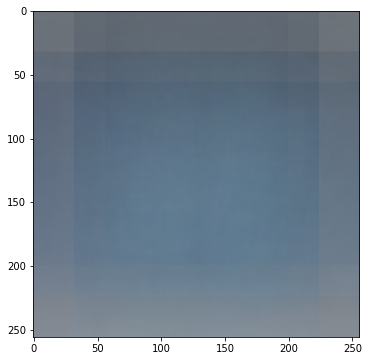

In [9]:
#store mean, variance not necessary as of same scale.
mean_img = np.mean(x_train, axis=0)
print 'mean image size : ', mean_img.shape
plt.figure(figsize = (6,6))
plt.imshow(mean_img)

The lighter shade at outer region might be because of lower size of some images and hence numpy filling zero at those places

In [10]:
#normalize train and val images
x_train = x_train - mean_img
x_val = x_val - mean_img

In [11]:
# target variable - encoding numeric value
label_list = train_data['label'].tolist()
Y_train = {k:v+1 for v,k in enumerate(set(label_list))}
y_train = [Y_train[k] for k in label_list]   
y_train = np.array(y_train)

print Y_train

{'tea': 1, 'fish': 2, 'honey': 3, 'juice': 4, 'milk': 5, 'nuts': 6, 'sugar': 7, 'jam': 8, 'rice': 9, 'coffee': 10, 'oil': 11, 'flour': 12, 'corn': 13, 'chocolate': 14, 'water': 15, 'cereal': 16, 'pasta': 17, 'chips': 18, 'tomatosauce': 19, 'vinegar': 20, 'candy': 21, 'beans': 22, 'soda': 23, 'cake': 24, 'spices': 25}


In [12]:
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [13]:
y_train = to_categorical(y_train)

In [14]:
#Transfer learning with Inception V3 
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [15]:
## set model architechture 
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [ ]:
batch_size = 32 # tune it
epochs = 5 # increase it

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

In [ ]:
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/5
80/80 [==============================] - 10878s - loss: 3.2090 - acc: 0.0918   

/home/ayush/Documents/Deep_Learning_Comp/.env/lib/python2.7/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/5
79/80 [============================>.] - ETA: 135s - loss: 2.9335 - acc: 0.1656

In [ ]:
## predict val data
predictions = model.predict(x_val)

In [ ]:
Y_val = {k:v+1 for v,k in enumerate(set(label_list))}
y_val = [Y_val[k] for k in label_list]   
y_val = np.array(y_val)